In [1]:
import gc
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, roc_auc_score
from lightgbm.sklearn import LGBMClassifier
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
def get_prev_months(year, month, num):
    for i in range(num):
        yield (year, month)
        if month==1:
            year-=1
            month=12
        else:
            month-=1

In [3]:
df_1 = pd.read_csv('data/y_Q1.csv')
df_3 = pd.read_csv('data/y_Q3.csv')
df_4 = pd.read_csv('data/y_Q4.csv')

# 前一季度资金变化

In [4]:
df_4 = df_4.merge(df_3[['cust_no', 'label']].rename({'label': 'prev_label'}, axis=1), on='cust_no', how='left')
df_1 = df_1.merge(df_4[['cust_no', 'label']].rename({'label': 'prev_label'}, axis=1), on='cust_no', how='left')

# 用户资产数据（月）

In [5]:
aum = pd.read_pickle('data/aum_month.pkl')
aum.head()

,cust_no,X1,X2,X3,X4,X5,X6,X7,X8,year,month
0,0xb2d67148,0.0,0.0,0.00,0,0.0,0.0,0.0,0,2019,10
1,0xb2d06707,0.0,0.0,0.00,0,0.0,0.0,0.0,0,2019,10
2,0xb2d7a54f,0.0,0.0,0.00,0,0.0,0.0,0.0,0,2019,10
3,0xb2d3d976,27000.0,0.0,25037.87,50000,0.0,0.0,0.0,0,2019,10
4,0xb2d1abaf,0.0,0.0,0.00,0,0.0,0.0,0.0,0,2019,10


In [6]:
def aum_feats(df, aum, year, month, num_months):
    for t, (y, m) in enumerate(get_prev_months(year, month, num_months)):
        # 月末资产 x1-x8
        tmp = aum[(aum.year==y)&(aum.month==m)]
        # 月末资产总和 x9
        tmp['X9'] = tmp[['X{}'.format(i) for i in range(1,9)]].sum(axis=1)
        # 月末资产比例 X10-X17
        for i in range(1,9):
            tmp['X{}'.format(i+9)] = tmp['X{}'.format(i)] / tmp['X9']
        # 重命名 X1-X17
        tmp = tmp.rename(dict([('X{}'.format(i), 'X{}_{}'.format(i, t)) for i in range(1,18)]), axis=1)
        del tmp['year']
        del tmp['month']
        df = df.merge(tmp, how='left', on='cust_no')
    for i in range(1,18):
        df['X{}_3m_min'.format(i)] = df[['X{}_{}'.format(i,j) for j in range(3)]].min(axis=1)
        df['X{}_3m_max'.format(i)] = df[['X{}_{}'.format(i,j) for j in range(3)]].max(axis=1)
        df['X{}_3m_std'.format(i)] = df[['X{}_{}'.format(i,j) for j in range(3)]].std(axis=1)
        df['X{}_3m_mean'.format(i)] = df[['X{}_{}'.format(i,j) for j in range(3)]].mean(axis=1)
        df['X{}_01'.format(i)] = df['X{}_0'.format(i)] - df['X{}_1'.format(i)]
        df['X{}_02'.format(i)] = df['X{}_0'.format(i)] - df['X{}_2'.format(i)]
        df['X{}_12'.format(i)] = df['X{}_1'.format(i)] - df['X{}_2'.format(i)]
        if num_months == 6:
            df['X{}_6m_min'.format(i)] = df[['X{}_{}'.format(i,j) for j in range(6)]].min(axis=1)
            df['X{}_6m_max'.format(i)] = df[['X{}_{}'.format(i,j) for j in range(6)]].max(axis=1)
            df['X{}_6m_std'.format(i)] = df[['X{}_{}'.format(i,j) for j in range(6)]].std(axis=1)
            df['X{}_6m_mean'.format(i)] = df[['X{}_{}'.format(i,j) for j in range(6)]].mean(axis=1)
            df['X{}_03'.format(i)] = df['X{}_0'.format(i)] - df['X{}_3'.format(i)]
            df['X{}_04'.format(i)] = df['X{}_0'.format(i)] - df['X{}_4'.format(i)]
            df['X{}_05'.format(i)] = df['X{}_0'.format(i)] - df['X{}_5'.format(i)]
            del df['X{}_3'.format(i)]
            del df['X{}_4'.format(i)]
            del df['X{}_5'.format(i)]
        del df['X{}_1'.format(i)]
        del df['X{}_2'.format(i)]
    return df

In [7]:
df_3 = aum_feats(df_3, aum, 2019, 9, 3)
df_4 = aum_feats(df_4, aum, 2019, 12, 6)
df_1 = aum_feats(df_1, aum, 2020, 3, 6)

In [9]:
del aum
gc.collect()

44

# 用户行为数据（月）

In [10]:
behavior = pd.read_pickle('data/behavior_month.pkl')
behavior.head()

,cust_no,B1,B2,B3,B4,B5,year,month,B6,B7
0,0xb2d5b142,0,1,2264.0,0,0.0,2019,11,NaT,NaN
1,0xb2d5e978,3,0,0.0,1,1633.0,2019,11,NaT,NaN
2,0xb2d55064,0,0,0.0,0,0.0,2019,11,NaT,NaN
3,0xb2d1a472,0,0,0.0,0,0.0,2019,11,NaT,NaN
4,0xb2d1d306,0,0,0.0,0,0.0,2019,11,NaT,NaN


In [11]:
def behavior_feats(df, behavior, year, month, num_months):
    for t, (y, m) in enumerate(get_prev_months(year, month, num_months)):
        # 客户行为数据 B1-B7
        tmp = behavior[(behavior.year==y)&(behavior.month==m)]
        del tmp['B6']
        del tmp['B7']
        # 平均转账转入金额 B8
        tmp['B8'] = tmp['B3'] / tmp['B2']
        # 平均转账转出金额 B9
        tmp['B9'] = tmp['B5'] / tmp['B4']
        # 总转账次数 B10
        tmp['B10'] = tmp['B2'] + tmp['B4']
        # 转账净额 B11
        tmp['B11'] = tmp['B5'] - tmp['B3']
        # 转账次数-登录网银次数 B12
        tmp['B12'] = tmp['B10'] - tmp['B1']
        # 重命名 B1-B12
        tmp = tmp.rename(dict([('B{}'.format(i), 'B{}_{}'.format(i, t)) for i in range(1, 13)]), axis=1)
        del tmp['year']
        del tmp['month']
        df = df.merge(tmp, how='left', on='cust_no')
    for i in range(1, 13):
        if i == 6 or i == 7:
            continue
        df['B{}_3m_sum'.format(i)] = df[['B{}_{}'.format(i,j) for j in range(3)]].sum(axis=1)
        df['B{}_3m_min'.format(i)] = df[['B{}_{}'.format(i,j) for j in range(3)]].min(axis=1)
        df['B{}_3m_max'.format(i)] = df[['B{}_{}'.format(i,j) for j in range(3)]].max(axis=1)
        df['B{}_3m_std'.format(i)] = df[['B{}_{}'.format(i,j) for j in range(3)]].std(axis=1)
        df['B{}_3m_mean'.format(i)] = df[['B{}_{}'.format(i,j) for j in range(3)]].mean(axis=1)
        df['B{}_3m_01'.format(i)] = df['B{}_0'.format(i)] - df['B{}_1'.format(i)]
        df['B{}_3m_02'.format(i)] = df['B{}_0'.format(i)] - df['B{}_2'.format(i)]
        df['B{}_3m_12'.format(i)] = df['B{}_1'.format(i)] - df['B{}_2'.format(i)]
        if num_months == 6:
            df['B{}_6m_sum'.format(i)] = df[['B{}_{}'.format(i,j) for j in range(6)]].sum(axis=1)
            df['B{}_6m_min'.format(i)] = df[['B{}_{}'.format(i,j) for j in range(6)]].min(axis=1)
            df['B{}_6m_max'.format(i)] = df[['B{}_{}'.format(i,j) for j in range(6)]].max(axis=1)
            df['B{}_6m_std'.format(i)] = df[['B{}_{}'.format(i,j) for j in range(6)]].std(axis=1)
            df['B{}_6m_mean'.format(i)] = df[['B{}_{}'.format(i,j) for j in range(6)]].mean(axis=1)
            df['B{}_03'.format(i)] = df['B{}_0'.format(i)] - df['B{}_3'.format(i)]
            df['B{}_04'.format(i)] = df['B{}_0'.format(i)] - df['B{}_4'.format(i)]
            df['B{}_05'.format(i)] = df['B{}_0'.format(i)] - df['B{}_5'.format(i)]
            del df['B{}_3'.format(i)]
            del df['B{}_4'.format(i)]
            del df['B{}_5'.format(i)]
        del df['B{}_1'.format(i)]
        del df['B{}_2'.format(i)]
    # 季度平均 B8 B9
    df['B8_3m'] = df['B3_3m_sum'] / df['B2_3m_sum']
    df['B9_3m'] = df['B5_3m_sum'] / df['B4_3m_sum']
    if num_months == 6:
        df['B8_6m'] = df['B3_6m_sum'] / df['B2_6m_sum']
        df['B9_6m'] = df['B5_6m_sum'] / df['B4_6m_sum']
    # 季度内最近一次交易时间 B6，季度内动账次数 B7
    tmp = behavior[(behavior.year==year)&(behavior.month==month)][['cust_no', 'B6', 'B7']]
    if month == 12:
        month = 1
        year += 1
    else:
        month += 1
    tmp['B6_hour'] = tmp['B6'].dt.hour
    tmp['B6'] = (pd.to_datetime('{:04d}{:02d}{:02d}'.format(year, month, 1)) - tmp['B6']).dt.days
    df = df.merge(tmp, how='left', on='cust_no')
    return df

In [12]:
df_3 = behavior_feats(df_3, behavior, 2019, 9, 3)
df_4 = behavior_feats(df_4, behavior, 2019, 12, 6)
df_1 = behavior_feats(df_1, behavior, 2020, 3, 6)

In [14]:
del behavior
gc.collect()

69

# 用户存款数据（月）

In [15]:
cunkuan = pd.read_pickle('data/cunkuan_month.pkl')
cunkuan.head()

,cust_no,C1,C2,year,month
0,0xb2d3ad96,231097.73,6,2019,11
1,0xb2d636da,600098.92,7,2019,11
2,0xb2d37469,0.00,1,2019,11
3,0xb2d636d4,0.31,1,2019,11
4,0xb2d3d20b,140007.62,3,2019,11


In [16]:
def cunkuan_feats(df, cunkuan, year, month, num_months):
    for t, (y, m) in enumerate(get_prev_months(year, month, num_months)):
        # 存款数据 C1-C2
        tmp = cunkuan[(cunkuan.year==y)&(cunkuan.month==m)]
        del tmp['year']
        del tmp['month']
        # 平均产品存款金额 C3
        tmp['C3'] = tmp['C1'] / tmp['C2']
        # 重命名 C1-C3
        tmp.rename(dict([('C{}'.format(i), 'C{}_{}'.format(i, t)) for i in range(1,4)]), axis=1, inplace=True)
        df = df.merge(tmp, how='left', on='cust_no')
    for i in range(1,4):
        df['C{}_3m_min'.format(i)] = df[['C{}_{}'.format(i,j) for j in range(3)]].min(axis=1)
        df['C{}_3m_max'.format(i)] = df[['C{}_{}'.format(i,j) for j in range(3)]].max(axis=1)
        df['C{}_3m_std'.format(i)] = df[['C{}_{}'.format(i,j) for j in range(3)]].std(axis=1)
        df['C{}_3m_mean'.format(i)] = df[['C{}_{}'.format(i,j) for j in range(3)]].mean(axis=1)
        df['C{}_3m_01'.format(i)] = df['C{}_0'.format(i)] - df['C{}_1'.format(i)]
        df['C{}_3m_02'.format(i)] = df['C{}_0'.format(i)] - df['C{}_2'.format(i)]
        df['C{}_3m_12'.format(i)] = df['C{}_1'.format(i)] - df['C{}_2'.format(i)]
        if num_months == 6:
            df['C{}_6m_min'.format(i)] = df[['C{}_{}'.format(i,j) for j in range(6)]].min(axis=1)
            df['C{}_6m_max'.format(i)] = df[['C{}_{}'.format(i,j) for j in range(6)]].max(axis=1)
            df['C{}_6m_std'.format(i)] = df[['C{}_{}'.format(i,j) for j in range(6)]].std(axis=1)
            df['C{}_6m_mean'.format(i)] = df[['C{}_{}'.format(i,j) for j in range(6)]].mean(axis=1)
            df['C{}_6m_03'.format(i)] = df['C{}_0'.format(i)] - df['C{}_3'.format(i)]
            df['C{}_6m_04'.format(i)] = df['C{}_0'.format(i)] - df['C{}_4'.format(i)]
            df['C{}_6m_05'.format(i)] = df['C{}_0'.format(i)] - df['C{}_5'.format(i)]
            del df['C{}_3'.format(i)]
            del df['C{}_4'.format(i)]
            del df['C{}_5'.format(i)]
        del df['C{}_1'.format(i)]
        del df['C{}_2'.format(i)]
    return df

In [17]:
df_3 = cunkuan_feats(df_3, cunkuan, 2019, 9, 3)
df_4 = cunkuan_feats(df_4, cunkuan, 2019, 12, 6)
df_1 = cunkuan_feats(df_1, cunkuan, 2020, 3, 6)

In [19]:
del cunkuan
gc.collect()

44

# 用户重大事件(季度)

In [20]:
event = pd.read_pickle('data/event_season.pkl')
event.head()

,cust_no,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16,E17,E18,year,season
0,0xb2d53438,2018-08-06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0.0,NaT,0.0,NaT,2019,4
1,0xb2d10cbd,2015-10-20,2015-10-20,2015-10-20,2015-10-27,NaT,NaT,NaT,NaT,NaT,2016-02-03,NaT,NaT,NaT,NaT,0.0,NaT,120000.0,2015-10-22,2019,4
2,0xb2d594c5,2018-09-25,2018-09-25,2018-09-25,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0.0,NaT,0.0,NaT,2019,4
3,0xb2d9ee51,2019-11-19,2019-11-19,2019-11-19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0.0,NaT,0.0,NaT,2019,4
4,0xb2d7bb80,2019-08-14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0.0,NaT,0.0,NaT,2019,4


In [21]:
del event['E11']

In [22]:
def event_feats(df, event, year, season):
    tmp = event[(event.year==year)&(event.season==season)]
    del tmp['year']
    del tmp['season']
    month = season * 3
    if month == 12:
        month = 1
        year += 1
    else:
        month += 1
    # 重大事件日期 E1-E4，E16,E18，金额 E15,E17
    date_feats = ['E1','E2','E3','E4','E5','E6','E7','E8','E9','E10','E12','E13','E14','E16','E18']
    for f in date_feats:
        tmp[f] = (pd.to_datetime('{:04d}{:02d}{:02d}'.format(year, month, 1))-tmp[f]).dt.days
    # 重大事件时间差
    for i in range(len(date_feats)):
        for j in range(i+1,len(date_feats)):
            tmp['{}_{}'.format(date_feats[i],date_feats[j])] = tmp[date_feats[i]] - tmp[date_feats[j]]
    df = df.merge(tmp, on='cust_no', how='left')
    del tmp
    # B6时间差
    for f in date_feats:
        df['{}_{}'.format(f, 'B6')] = df[f] - df['B6']
    return df

In [23]:
df_3 = event_feats(df_3, event, 2019, 3)
df_4 = event_feats(df_4, event, 2019, 4)
df_1 = event_feats(df_1, event, 2020, 1)

In [25]:
del event
gc.collect()

44

# 客户信息（季度）

In [26]:
custinfo = pd.read_pickle('data/custinfo_season.pkl')
custinfo.head()

,cust_no,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15,I16,I17,I18,I19,I20,year,season
0,0xb2d5fd8e,男性,26,普通客户,0.0,商业工作人员,0,0,白羊座,NaN,NaN,0.0,个人,NaN,NaN,0,0.0,1,1,1,0,2020,1
1,0xb2d811d2,男性,25,普通客户,0.0,不便分类的其他从业人员,0,0,天蝎座,NaN,未知,0.0,个人,未说明的婚姻状况,未知,0,0.0,0,0,0,0,2020,1
2,0xb2d8b1c8,女性,43,普通客户,0.0,商业工作人员,0,0,水瓶座,NaN,NaN,0.0,个人,NaN,NaN,0,0.0,0,0,0,0,2020,1
3,0xb2db077a,女性,58,普通客户,0.0,服务性工作人员,0,0,双鱼座,NaN,NaN,0.0,个人,NaN,NaN,0,0.0,1,1,1,0,2020,1
4,0xb2da6784,男性,24,普通客户,0.0,服务性工作人员,0,0,双子座,NaN,NaN,0.0,个人,NaN,NaN,0,0.0,1,1,1,0,2020,1


In [27]:
del custinfo['I7']
del custinfo['I9']

<AxesSubplot:xlabel='I2', ylabel='Density'>

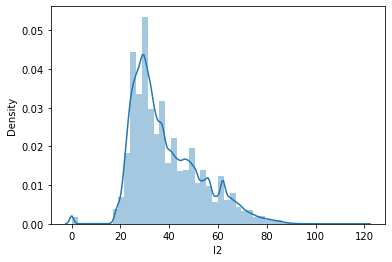

In [28]:
custinfo.loc[(custinfo.I2<0)|(custinfo.I2>120), 'I2'] = np.NaN
sns.distplot(custinfo.I2)

In [29]:
for f in [f for f in custinfo.select_dtypes('object').columns if f not in ['label', 'cust_no']]:
    custinfo[f] = LabelEncoder().fit_transform(custinfo[f].fillna('未知'))

In [30]:
custinfo.head()

,cust_no,I1,I2,I3,I4,I5,I6,I8,I10,I11,I12,I13,I14,I15,I16,I17,I18,I19,I20,year,season
0,0xb2d5fd8e,2,26.0,0,0.0,12,0,11,8,0.0,1,4,4,0,0.0,1,1,1,0,2020,1
1,0xb2d811d2,2,25.0,0,0.0,0,0,4,8,0.0,1,5,4,0,0.0,0,0,0,0,2020,1
2,0xb2d8b1c8,0,43.0,0,0.0,12,0,9,8,0.0,1,4,4,0,0.0,0,0,0,0,2020,1
3,0xb2db077a,0,58.0,0,0.0,17,0,1,8,0.0,1,4,4,0,0.0,1,1,1,0,2020,1
4,0xb2da6784,2,24.0,0,0.0,17,0,0,8,0.0,1,4,4,0,0.0,1,1,1,0,2020,1


In [31]:
def custinfo_feats(df, custinfo, year, season):
    tmp = custinfo[(custinfo.year==year)&(custinfo.season==season)]
    del tmp['year']
    del tmp['season']
    for f in ['I1','I3','I4','I5','I6','I8','I10','I12','I13','I14','I15','I16','I17','I18','I19','I20']:
        tmp['{}_count'.format(f)] = tmp[f].map(tmp[f].value_counts())
    df = df.merge(tmp, on='cust_no', how='left')
    return df

In [32]:
df_3 = custinfo_feats(df_3, custinfo, 2019, 3)
df_4 = custinfo_feats(df_4, custinfo, 2019, 4)
df_1 = custinfo_feats(df_1, custinfo, 2020, 1)

In [34]:
del custinfo
gc.collect()

114

# 目标编码

In [35]:
def func(s, f):
    tmp = dict(s.value_counts().sort_index() / len(s))
    return pd.Series({
        f: s.name,
        '{}_target_0'.format(f): tmp[-1] if -1 in tmp else np.NaN,
        '{}_target_1'.format(f): tmp[0] if 0 in tmp else np.NaN,
        '{}_target_2'.format(f): tmp[1] if 1 in tmp else np.NaN,
        '{}_target_mean'.format(f): s.mean(),
    })
def target_encoding(df_train, df_test, f):
    f_name = '_'.join(f)
    #df_test
    enc_df = df_train.groupby(f, as_index=False).label.apply(lambda s: func(s, f_name))
    df_test = df_test.merge(enc_df, on=f, how='left')
    # df_train
    df_train['{}_target_0'.format(f_name)] = 0
    df_train['{}_target_1'.format(f_name)] = 0
    df_train['{}_target_2'.format(f_name)] = 0
    df_train['{}_target_mean'.format(f_name)] = 0
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
    for trn_idx, val_idx in skf.split(df_train, df_train.label):
        trn_x = df_train.iloc[trn_idx][f+['label']].reset_index(drop=True)
        val_x = df_train.iloc[val_idx][f].reset_index(drop=True)
        enc_df = trn_x.groupby(f, as_index=False).label.apply(lambda s: func(s, f_name))
        val_x = val_x.merge(enc_df, on=f, how='left')
        df_train.loc[val_idx, '{}_target_0'.format(f_name)] = val_x['{}_target_0'.format(f_name)].values
        df_train.loc[val_idx, '{}_target_1'.format(f_name)] = val_x['{}_target_1'.format(f_name)].values
        df_train.loc[val_idx, '{}_target_2'.format(f_name)] = val_x['{}_target_2'.format(f_name)].values
        df_train.loc[val_idx, '{}_target_mean'.format(f_name)] = val_x['{}_target_mean'.format(f_name)].values
    return df_train, df_test

In [36]:
df_4, df_1 = target_encoding(df_4, df_1, ['prev_label'])

In [ ]:
df_train = df_4
df_test = df_1
del df_3
del df_4
del df_1
gc.collect()

In [38]:
for f in ['I1','I3','I4','I5','I6','I8','I10','I12','I13','I14','I15','I16','I17','I18','I19','I20']:
    df_train, df_test = target_encoding(df_train, df_test, [f])

# 训练模型

<AxesSubplot:xlabel='label', ylabel='count'>

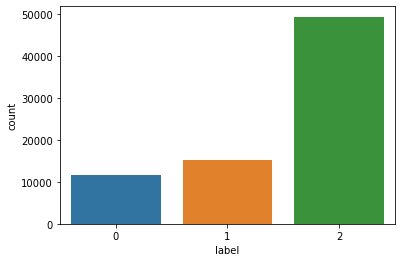

In [39]:
df_train['label'] += 1
sns.countplot(df_train.label)

In [42]:
class_weight = dict(df_train.shape[0] / (3 * df_train.label.value_counts()))
feats = df_train.columns.drop(['cust_no', 'label']).values
cate_feats = ['I1','I3','I4','I5','I6','I8','I10','I12','I13','I14','I15','I16','I17','I18','I19','I20']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

In [43]:
oof = np.zeros(shape=(df_train.shape[0], 3))
sub = np.zeros(shape=(df_test.shape[0], 3))
imp = np.zeros(len(feats))

In [44]:
def kappa(y_true, y_pred):
    y_pred = np.argmax(y_pred.reshape(3, -1), axis=0)
    score = cohen_kappa_score(y_true, y_pred)
    return 'kappa', score, True
start = time.time()
for i, (trn_idx, val_idx) in enumerate(skf.split(df_train, df_train.label)):
    print('-------------------------- {} fold--------------------------'.format(i+1))
    X_trn, Y_trn = df_train.iloc[trn_idx][feats], df_train.iloc[trn_idx].label
    X_val, Y_val = df_train.iloc[val_idx][feats], df_train.iloc[val_idx].label
    X_sub = df_test[feats]
    clf = LGBMClassifier(
        num_class=3,
        objective='multiclass',
        class_weight=class_weight,
        learning_rate=0.02,
        num_leaves=255,
        n_estimators=100000,
        subsample_freq=1,
        subsample=0.6,
        colsample_bytree=0.6,
        min_child_weight=10,
        random_state=2020,
        n_jobs=16,
    )
    clf.fit(
        X_trn, Y_trn,
        eval_set=[(X_val, Y_val)],
        categorical_feature=cate_feats,
        eval_metric=kappa,
        early_stopping_rounds=500,
        verbose=200,
    )
    oof[val_idx] = clf.predict_proba(X_val)
    sub += clf.predict_proba(X_sub) / skf.n_splits
    imp += clf.feature_importances_ / skf.n_splits
end = time.time()

-------------------------- 1 fold--------------------------
Training until validation scores don't improve for 500 rounds
[200]	valid_0's multi_logloss: 0.662186	valid_0's kappa: 0.49346
[400]	valid_0's multi_logloss: 0.634691	valid_0's kappa: 0.498005
[600]	valid_0's multi_logloss: 0.627707	valid_0's kappa: 0.493376
[800]	valid_0's multi_logloss: 0.631468	valid_0's kappa: 0.491643
Early stopping, best iteration is:
[444]	valid_0's multi_logloss: 0.632132	valid_0's kappa: 0.500787
-------------------------- 2 fold--------------------------
Training until validation scores don't improve for 500 rounds
[200]	valid_0's multi_logloss: 0.666203	valid_0's kappa: 0.47312
[400]	valid_0's multi_logloss: 0.637842	valid_0's kappa: 0.478309
[600]	valid_0's multi_logloss: 0.631833	valid_0's kappa: 0.482479
[800]	valid_0's multi_logloss: 0.635891	valid_0's kappa: 0.481118
[1000]	valid_0's multi_logloss: 0.644446	valid_0's kappa: 0.482808
Early stopping, best iteration is:
[584]	valid_0's multi_loglo

In [45]:
print('cost time: {:.2f} min'.format((end-start)/60))
print('train kappa: {:.4f}'.format(cohen_kappa_score(df_train.label, np.argmax(oof, axis=1))))
print('train acc: {:.4f}'.format(accuracy_score(df_train.label, np.argmax(oof,axis=1))))

cost time: 18.50 min
train kappa: 0.4927
train acc: 0.7341


<AxesSubplot:xlabel='imp', ylabel='feat'>

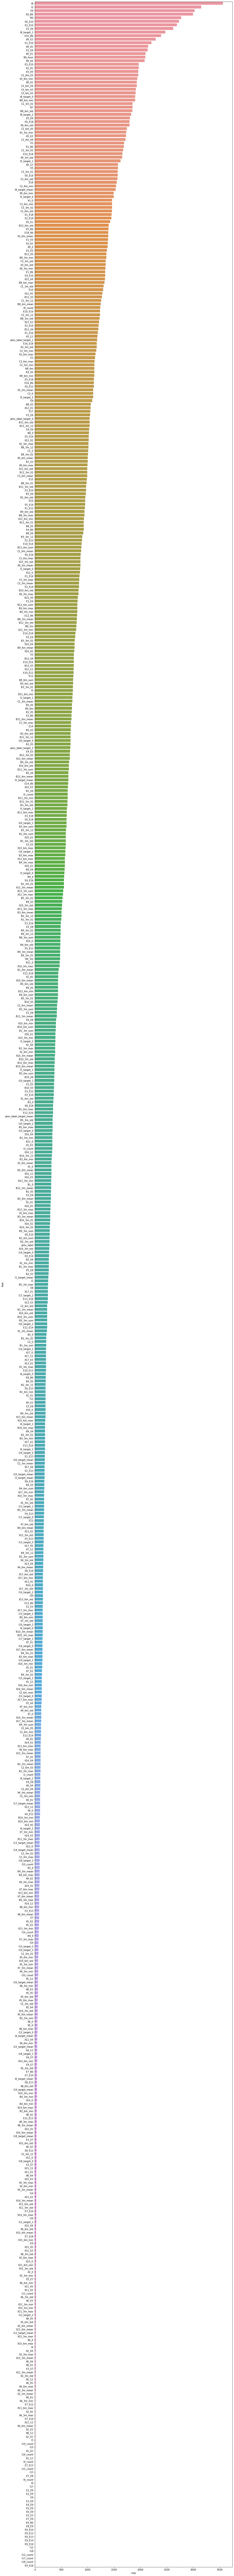

In [46]:
df_feats_imp = pd.DataFrame({
    'feat': feats,
    'imp': imp,
}).sort_values('imp',ascending=False).reset_index(drop=True)
plt.figure(figsize=(15, 200))
sns.barplot(x='imp', y='feat', data=df_feats_imp)

# 9. 保存结果

In [47]:
pd.DataFrame({
    'cust_no': df_train.cust_no,
    'label': df_train.label,
    'prob_0': oof[:,0],
    'prob_1': oof[:,1],
    'prob_2': oof[:,2],
}).to_csv('oof.csv', index=False)

In [48]:
pd.DataFrame({
    'cust_no': df_test.cust_no,
    'prob_0': sub[:,0],
    'prob_1': sub[:,1],
    'prob_2': sub[:,2],
}).to_csv('sub.csv', index=False)

<AxesSubplot:xlabel='label', ylabel='count'>

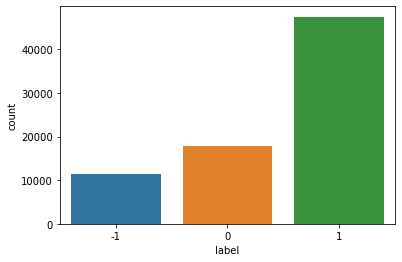

In [49]:
pred = pd.DataFrame({
    'cust_no': df_test.cust_no,
    'label': np.argmax(sub, axis=1) -1,
})
pred.to_csv('submission.csv', index=False)
sns.countplot(pred.label)